In [2]:
!pip install -q grad-cam
!apt-get install wkhtmltopdf
!pip install pdfkit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.6 MB/s eta 0:00:00:00:0100:01
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will 

In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import pdfkit
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image


In [2]:
data_dir = "/kaggle/input/refuge2/REFUGE2"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(os.path.join(data_dir, "train"), transform=transform)
test_dataset = ImageFolder(os.path.join(data_dir, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [3]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
for epoch in range(5):  # Keep epochs low for Kaggle runtime
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")


100%|██████████| 50/50 [01:01<00:00,  1.22s/it]


Epoch 1, Loss: 0.0252


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


Epoch 2, Loss: 0.0003


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


Epoch 3, Loss: 0.0002


100%|██████████| 50/50 [00:47<00:00,  1.04it/s]


Epoch 4, Loss: 0.0001


100%|██████████| 50/50 [00:47<00:00,  1.04it/s]

Epoch 5, Loss: 0.0001


In [33]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def generate_gradcam(model, img_path, label):
    model.eval()
    image = Image.open(img_path).convert('RGB')
    rgb_img = np.array(image.resize((224, 224))) / 255.0
    rgb_img = np.float32(rgb_img)

    tensor_img = transform(image).unsqueeze(0).to(device)

    # No 'use_cuda'
    cam = GradCAM(model=model, target_layers=[model.layer4[-1]])
    grayscale_cam = cam(input_tensor=tensor_img, targets=None)[0]

    cam_img = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    
    # Display heatmap
    plt.imshow(cam_img)
    plt.title(f"Grad-CAM for {label}")
    plt.axis('off')
    plt.show()

    return cam_img


In [38]:
def generate_html_report(patient_id, diagnosis, confidence, cam_img_path):
    base64_img = encode_image_to_base64(cam_img_path)

    # Determine if glaucoma was detected based on the diagnosis string
    glaucoma_detected = "glaucoma" in diagnosis.lower() or "positive" in diagnosis.lower()
    
    # Explanation text depending on detection
    if glaucoma_detected:
        detection_text = "Glaucoma Detected"
        reason_text = (
            "The model identified characteristic patterns in the optic disc region "
            "consistent with glaucomatous optic neuropathy. Key features include thinning "
            "of the neuroretinal rim and increased cup-to-disc ratio, which are typical markers "
            "of glaucoma progression."
        )
    else:
        detection_text = "No Glaucoma Detected"
        reason_text = (
            "The analysis did not reveal significant glaucomatous changes in the optic disc. "
            "The neuroretinal rim and cup-to-disc ratio appear within normal limits, "
            "suggesting no current evidence of glaucoma."
        )

    html_content = f"""
    <html>
    <head>
        <style>
            body {{
                font-family: 'Arial', sans-serif;
                padding: 40px;
                line-height: 1.6;
            }}
            h1 {{
                color: #2c3e50;
                border-bottom: 2px solid #2c3e50;
            }}
            img {{
                max-width: 100%;
                height: auto;
                border: 1px solid #ddd;
                margin-top: 10px;
            }}
            .detection {{
                font-size: 1.2em;
                font-weight: bold;
                margin: 20px 0;
                color: {'#e74c3c' if glaucoma_detected else '#27ae60'};
            }}
        </style>
    </head>
    <body>
        <h1>Patient Report: {patient_id}</h1>
        <p><strong>Diagnosis:</strong> {diagnosis}</p>
        <p><strong>Model Confidence:</strong> {confidence:.2f}%</p>

        <p class="detection">{detection_text}</p>

        <div class="section">
            <p><strong>Reason for Diagnosis:</strong></p>
            <p>{reason_text}</p>
        </div>

        <div class="section">
            <p><strong>Explanation:</strong></p>
            <p>
                Based on deep learning analysis using Grad-CAM, the highlighted region (shown in red on the image below) represents areas of the optic disc that the model considers most indicative of glaucomatous changes. This typically corresponds to regions where the neuroretinal rim appears thinned or the cup-to-disc ratio is elevated.
            </p>
            <p>
                Increased attention in these areas suggests possible structural abnormalities consistent with glaucomatous optic neuropathy. The highlighted zone may reflect early signs of retinal nerve fiber layer (RNFL) loss or focal notching, which warrant further clinical evaluation using optical coherence tomography (OCT) and intraocular pressure (IOP) measurements.
            </p>
        </div>

        <div class="section">
            <p><strong>Visual Explanation (Grad-CAM Heatmap):</strong></p>
            <img src="data:image/png;base64,{base64_img}" alt="Grad-CAM Heatmap">
        </div>

        <div class="section">
            <p><strong>Note:</strong> This report is AI-assisted and should be interpreted in conjunction with a comprehensive ophthalmological assessment.</p>
        </div>
    </body>
    </html>
    """

    html_path = f"/kaggle/working/{patient_id}_report.html"
    with open(html_path, "w") as f:
        f.write(html_content)
    return html_path


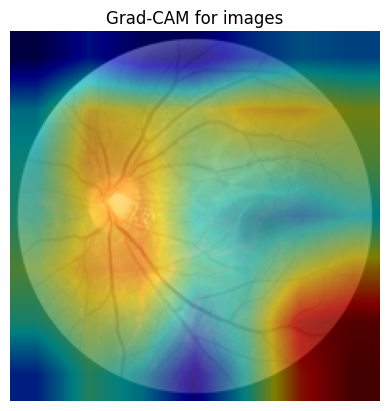

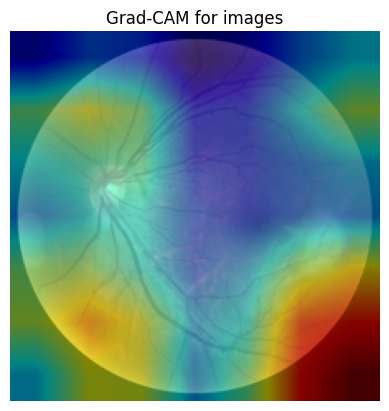

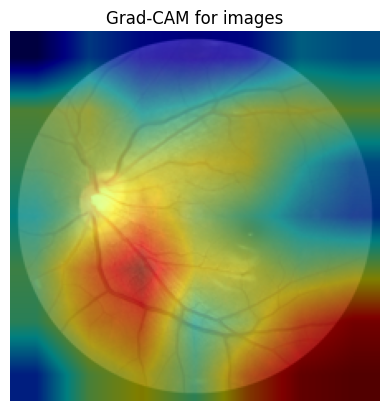

In [39]:
for i, (img, label) in enumerate(test_loader):
    img_path = test_dataset.samples[i][0]
    patient_id = os.path.basename(img_path).split('.')[0]

    with torch.no_grad():
        output = model(img.to(device))
        prob = torch.nn.functional.softmax(output, dim=1)
        pred_class = torch.argmax(prob, dim=1).item()
    
    pred_label = train_dataset.classes[pred_class]
    confidence = prob[0][pred_class].item() * 100
    
    cam_img = generate_gradcam(model, img_path, pred_label)
    cam_img_path = f"/kaggle/working/{patient_id}_cam.png"
    save_cam_image(cam_img, cam_img_path)
    
    html_report_path = generate_html_report(patient_id, pred_label, confidence, cam_img_path)


    # Optional: convert to PDF
    # pdfkit.from_file(html_report_path, f"/kaggle/working/{patient_id}_report.pdf")
    from weasyprint import HTML

    HTML(html_report_path).write_pdf(f"/kaggle/working/{patient_id}_report.pdf")


    if i == 2: break  # Generate only first 5 reports to save time


In [31]:
import base64

def encode_image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')


In [32]:
import cv2

def save_cam_image(cam_array, save_path):
    cv2.imwrite(save_path, cam_array)  # cam_array is a NumPy array (BGR or RGB)
